In [14]:
from pointcept.supplemental.preprocessing import ParametrixPreprocessor
import subprocess
import shutil
import logging
import sys
import re
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

from pointcept.supplemental.utils import get_category_list
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s', datefmt='%H:%M:%S')
logger = logging.getLogger(__name__)

In [2]:
p = ParametrixPreprocessor("library")

In [3]:
p.ensure_meshes(bin_file="/home/sogilvy/library.bin")
pcd_dict = p.generate_toy_pcds(total_points=20000, normalize_by_area=False)
kmeans = p.get_cluster_densities(pcd_dict, 20)

20:56:33 - INFO - Input .bin specified: /home/sogilvy/library.bin
20:56:33 - INFO - Label library already has extracted meshes.
20:56:34 - INFO - Generating toy pointclouds for categories ['1_WALL', '2_FLOOR', '3_ROOF', '4_CEILING', '5_FOOTPATH', '6_GRASS', '7_COLUMN', '8_DOOR', '9_WINDOW', '10_STAIR', '11_RAILING', '12_RWP'].
20:56:34 - INFO - Sampling 20000 total points. Normalize_by_area = False
20:56:43 - INFO -   Sampled 1666 points for category 1_WALL
20:56:44 - INFO -   Sampled 1666 points for category 2_FLOOR
20:56:44 - INFO -   Sampled 1666 points for category 3_ROOF
20:56:46 - INFO -   Sampled 1666 points for category 4_CEILING
20:56:46 - INFO -   Sampled 1666 points for category 5_FOOTPATH
20:56:46 - INFO -   Sampled 1666 points for category 6_GRASS
20:56:48 - INFO -   Sampled 1666 points for category 7_COLUMN
20:56:49 - INFO -   Sampled 1666 points for category 8_DOOR
20:56:50 - INFO -   Sampled 1666 points for category 9_WINDOW
20:56:53 - INFO -   Sampled 1666 points for c

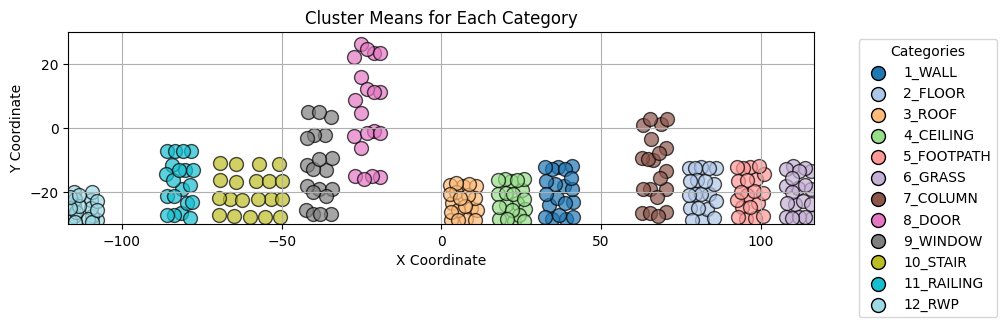

In [4]:
p.plot_cluster_means(kmeans, figure_scale=2.5)

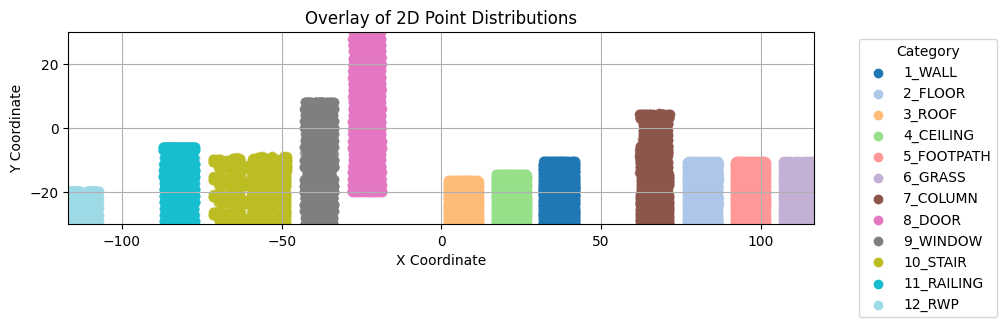

In [5]:
s = p.plot_overlay_2d_distributions(pcd_dict, 2.5)
s

In [16]:
def evaluate_binning(self, pcd_dict, num_bins_x=None, num_bins_y=None):
    """
    Evaluates a binning schema for a dictionary of Open3D point clouds using AABB from meshes for histogram limits,
    with evenly spaced bins in x and y. Defaults to creating bins approximately 8 units in size when not specified.

    Args:
        pcd_dict (dict): Dictionary where each key is a category and each value is an Open3D point cloud.
        num_bins_x (int): Optional. Number of bins to use in x dimension.
        num_bins_y (int): Optional. Number of bins to use in y dimension.

    Returns:
        dict: A dictionary with keys as categories and values as a 2D array of counts per bin.
    """
    # Use the AABB from all meshes to define the bin limits
    aabb = self.get_aabb_all_meshes()
    min_pt = aabb['min']
    max_pt = aabb['max']

    # Desired size of each bin in terms of units (approximately 8x8 units if not specified)
    desired_bin_size = 8

    # Compute default number of bins if not specified
    if num_bins_x is None:
        num_bins_x = max(1, int(np.round((max_pt[0] - min_pt[0]) / desired_bin_size)))
    if num_bins_y is None:
        num_bins_y = max(1, int(np.round((max_pt[1] - min_pt[1]) / desired_bin_size)))
    logger.info(f"Binning is using {num_bins_x} bins in X, and {num_bins_y} bins in Y.")
    # Create bin edges based on the AABB
    x_edges = np.linspace(min_pt[0], max_pt[0], num_bins_x + 1)
    y_edges = np.linspace(min_pt[1], max_pt[1], num_bins_y + 1)

    # Evaluate binning for each point cloud
    bin_counts = {}
    for category, pcd in pcd_dict.items():
        points = np.asarray(pcd.points)
        hist, _, _ = np.histogram2d(points[:, 0], points[:, 1], bins=(x_edges, y_edges))
        bin_counts[category] = hist

    return bin_counts


from types import MethodType
p.evaluate_binning = MethodType(evaluate_binning, p)

# Example usage
# Assuming you have a dictionary `pcd_dict` where values are loaded Open3D point clouds
binning_results = p.evaluate_binning(pcd_dict)

21:08:32 - INFO - Binning is using 29 bins in X, and 8 bins in Y.
